# Tutorial 5 - Working with topography

In this notebook I will demonstrate how to incorporate topography and information about the Moho into the inversion process and run a joint inversion for a model with topography. This usually consists of a number of steps:

- Interpolate the topography information onto the chosen grid
- Creating a starting model
- Creating a model covariance file that indicates which cells can be modified (within the Earth) and which cells should remain constant (in the air)
- Create a tear file for the regularization to avoid smoothing across the Earth-Air interface
- Specifying where the coupling between density and susceptibility should be applied (within the Earth) and where not (in the Air)

The last three steps require to create additional files. However, all three have very similar structure. We can use these files to incorporate complex prior information for each type of data individually. In the example, we also restrict the susceptibility inversion to the crust as the mantle is typically considered too hot to show significant magnetic susceptibility or magnetization. In contrast, the density model will be allowed to change everywhere within the Earth.

In [8]:
#As always we have to import a few packages
import numpy as np
from pyproj import CRS
from pyproj import Transformer
from netCDF4 import Dataset
import matplotlib.pyplot as plt

## Reading in topography

As in the previous examples we read in the magnetic data to determine the extent of our domain of interest.

In [60]:
#read in the measurement positions from the magnetic data file 
mag_fh = Dataset("magdata.nc", "r")
MeasX = mag_fh.variables["MeasPosX"][:]
MeasY = mag_fh.variables["MeasPosY"][:]
mag_fh.close()
print("Data spacing: ", np.sqrt((MeasX[0]-MeasX[1])**2+(MeasY[0]-MeasY[1])**2))
print ("Minimum x:", np.min(MeasX))
print ("Maximum x:", np.max(MeasX))
print ("Minimum y:", np.min(MeasY))
print ("Maximum y:", np.max(MeasY))

Data spacing:  15371.08646501342
Minimum x: 4605521.393365797
Maximum x: 5149347.908427868
Minimum y: 516331.66213522886
Maximum y: 998560.7410064917


We read in the topography information around the region of interest. Here we use a subset of the global ETOPO1 (https://www.ngdc.noaa.gov/mgg/global/) global relief model. Depending on the scale of interest you might want to use SRTM (https://earthexplorer.usgs.gov/) topography or even a local DEM model.

/tmp/ipykernel_6458/2670032648.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(TopoY,TopoX,topoz)


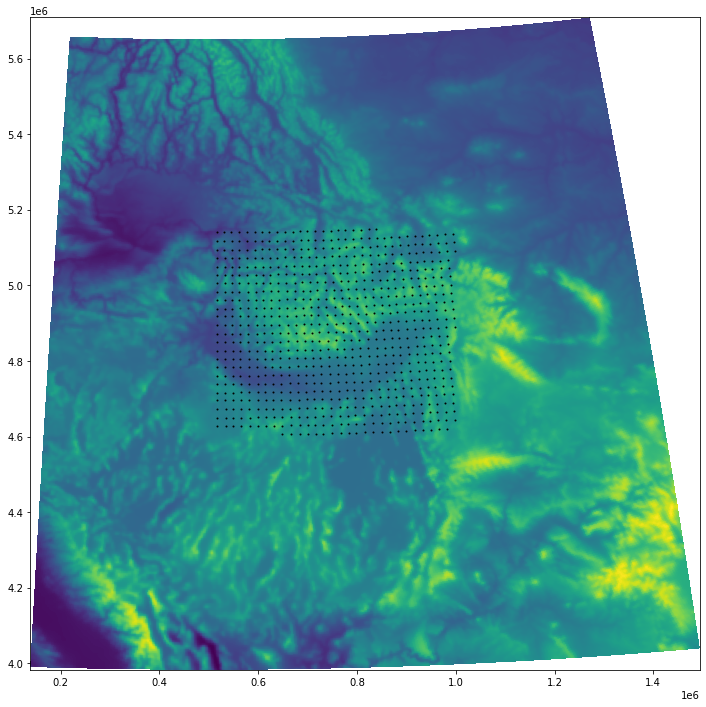

Minimum elevation:  -102.071945
Maximum elevation:  3786.0547


In [12]:
#define the coordinate transform
crs_4326 = CRS("WGS84")
crs_32611 = CRS("EPSG:32611")
transformer = Transformer.from_crs(crs_4326, crs_32611)
#Read in the topography grid

topo_fh = Dataset("topo20.grd", "r")
topolon = topo_fh.variables["lon"][:]
topolat = topo_fh.variables["lat"][:]
topoz = topo_fh.variables["z"][:,:]
topo_fh.close()
#project from lon lat to our local coordinate system
#myProj = Proj("+proj=utm +zone=11, +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
tla, tlo = np.meshgrid(topolon,topolat)
TopoY, TopoX = transformer.transform(tlo, tla)
#plot topography and the magnetic measurements
plt.figure(figsize=(12,12))
plt.pcolormesh(TopoY,TopoX,topoz)
plt.scatter(MeasY,MeasX, s=1, c='black')
plt.show()
print ("Minimum elevation: ", np.min(topoz))
print ("Maximum elevation: ", np.max(topoz))

## Creating a grid

To advance things slightly from previous tutorials we now create a grid that has varying cell size in horizontal and vertical directions. We define a core zone of size $nx \times ny \times nz$ cells and then add a padding zone around it in x- and y-direction. Typically it is a good idea not to vary cell sizes too much in the region of interest. The paddding zone helps us to incorporate features of the surroundings (e.g. wider topography) that do not need to be captured with the same accuracy.

*A word of caution*: For simplicity we are re-using the magnetic and gravity data from the previous examples. The magnetic data are all reported at a height of 10,000m so above the highest topography. In contrast, the gravity data all have a measurement hight of 30cm. As a result the measurements will end up within the Earth. This poses no numerical problem but is of course not a correct representation of the measurements. The solution would be to upward continue the gravity data to an elevation above the topography. This is beyond the scope of this tutorial and the main point is to demonstrate hwo to create complex starting models. Thus the results will not be correct in terms of Earth structure but only provide a general recipe of something like this could be done.

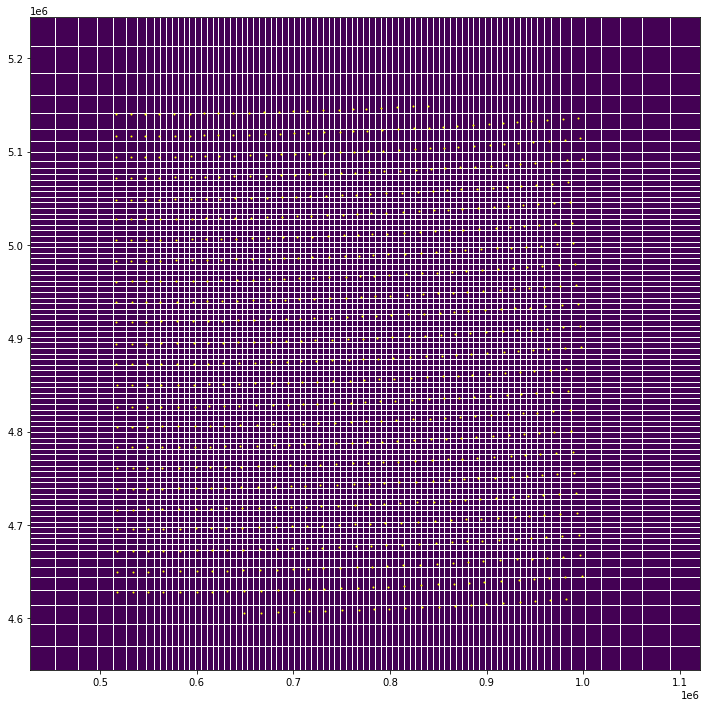

X-pad: [ 6000.  7200.  8640. 10368. 12442. 14930. 17916. 21499. 25799. 30959.]
Y-pad: [ 6000.  7200.  8640. 10368. 12442. 14930. 17916. 21499. 25799. 30959.]
X-center: 4877434.650896832
Y-center: 757446.2015708603
X-Origin: 4526681.650896832
Y-Origin: 409693.20157086034
Northing: [4557640.65089683 4583439.65089683 4604938.65089683 4622854.65089683
 4637784.65089683 4650226.65089683 4660594.65089683 4669234.65089683
 4676434.65089683 4682434.65089683 4688434.65089683 4694434.65089683
 4700434.65089683 4706434.65089683 4712434.65089683 4718434.65089683
 4724434.65089683 4730434.65089683 4736434.65089683 4742434.65089683
 4748434.65089683 4754434.65089683 4760434.65089683 4766434.65089683
 4772434.65089683 4778434.65089683 4784434.65089683 4790434.65089683
 4796434.65089683 4802434.65089683 4808434.65089683 4814434.65089683
 4820434.65089683 4826434.65089683 4832434.65089683 4838434.65089683
 4844434.65089683 4850434.65089683 4856434.65089683 4862434.65089683
 4868434.65089683 4874434.650

In [31]:
#set the total number of core cells in each direction
nx = 65
ny = 64
nz = 40
#how many horizontal padding cells do we want
padx = 10
pady = 10
#set the cell sizes in the core area in m, cells on the outside will grow
deltax = 6000.0
deltay = 6000.0
deltaz = 120.0
#the factor by which we increase layer thickness and size of padding cells
increasehor = 1.2
increasever = 1.1

#calculate the center position for the measurements
centerx = (np.min(MeasX) +  np.max(MeasX))/2.0
centery = (np.min(MeasY) + np.max(MeasY))/2.0

xpadspacing = np.round(deltax * np.power(increasehor,np.arange(0,padx)))
ypadspacing = np.round(deltay * np.power(increasehor,np.arange(0,pady)))
xpadwidth = np.sum(xpadspacing)
ypadwidth = np.sum(ypadspacing)
#calculate the model origin so the center of measurements is in the center of the model
startx = centerx - nx/2 * deltax - xpadwidth
starty = centery - ny/2 * deltay - ypadwidth
xpadbottom = startx + np.cumsum(xpadspacing[::-1])
ypadleft = starty + np.cumsum(ypadspacing[::-1])
xcore = xpadbottom[-1] + np.cumsum(np.ones(nx)*deltax)
ycore = ypadleft[-1] + np.cumsum(np.ones(ny)*deltay)
xpadtop = xcore[-1]  + np.cumsum(xpadspacing)
ypadright = ycore[-1]  + np.cumsum(ypadspacing)
Northing = np.concatenate((xpadbottom, xcore, xpadtop))
Easting =  np.concatenate((ypadleft, ycore, ypadright))
#when we consider topography we have to set the origin of the mesh in z-direction to the highest topography
#also remember positive down, so above ground is negative
startz = - np.round(np.max(topoz))
#calculate the layer thicknesses with depth
#we round to full meters because
# a) it is a bit ridiculous to work with sub meter precision when inverting lithospheric structures
# b) we run into all kinds of floating point precision issues when trying to compare numbers
thick = np.round(deltaz * np.power(increasever,np.arange(0,nz)))
#calculate layer depth from thickness
Depth = startz + np.cumsum(thick)
#calculate cell bounbdaries in north direction from specified number of cells and cell size


Density = np.zeros([nz,ny+2*pady,nx+2*padx])
bg_densities = np.zeros(nz)
bg_thickness = thick


ea, no = np.meshgrid(Easting,Northing)
plt.figure(figsize=(12,12))
plt.pcolormesh(ea,no,np.transpose(Density[0,:,:]),edgecolors='white')
plt.scatter(MeasY,MeasX, s=1, c='yellow')

plt.show()
print ("X-pad:", xpadspacing)
print ("Y-pad:", ypadspacing)
print ("X-center:", centerx)
print ("Y-center:", centery)
print ("X-Origin:", startx)
print ("Y-Origin:", starty)
print("Northing:", Northing)
print("Easting:", Easting)
print("Thicknesses:", thick)
print("Depth", Depth)

# Interpolating topography

To incorporate the topography into our mesh, we have to interpolat the information onto the cell centers. There are various ways to do this and you might want to experiment with different methods (e.g. linear vs. cubic) depending on your application. Here we perform a relatively simple linear interpolation.

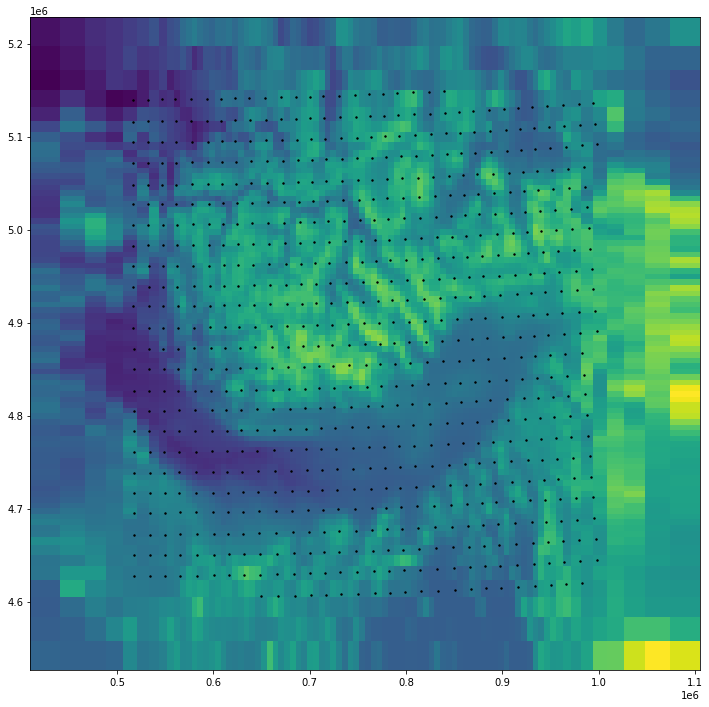

(85, 84)


In [32]:
# calculate the cell centers for our mesh
No = np.append(startx,Northing)
Ea = np.append(starty,Easting)
De = np.append(startz,Depth)
northmid = (No[:-1] + No[1:])/2.0
eastmid = (Ea[:-1] + Ea[1:])/2.0
grid_x, grid_y = np.meshgrid(eastmid, northmid)

#perform a linear interpolation of the topography onto those cell centers
import scipy.interpolate as sc
topointer = sc.griddata(np.c_[TopoY.flatten(),TopoX.flatten()],topoz.flatten(),(grid_x, grid_y), method='linear')

#plot the resulting topography at the resolution of the mesh
plt.figure(figsize=(12,12))
ea, no = np.meshgrid(Ea,No)
plt.pcolormesh(ea,no,topointer)
plt.scatter(MeasY,MeasX, s=2, c='black')
plt.show()


We can now make a starting model with different densities, for example. For air we assign a density of zero and for the Earth we use a very low density of 1 kg/m$^3$. This is mostly to illustrae the difference between Earth and Air in the plots below. In this case the gravity are complete Bouguer corrected. Therefore any influence of topography with homogeneous density should be removed from the data. In other cases you might want to use different values, e.g. when modelling free air anomaly data.

As you can see from the plot below, there can be differences between the interpolated topography and where the Air/Earth interface is located in the model. This depends on the vertical discretization of modelling domain. It can be useful to change the vertical discretization to ensure sufficiently precise representation.

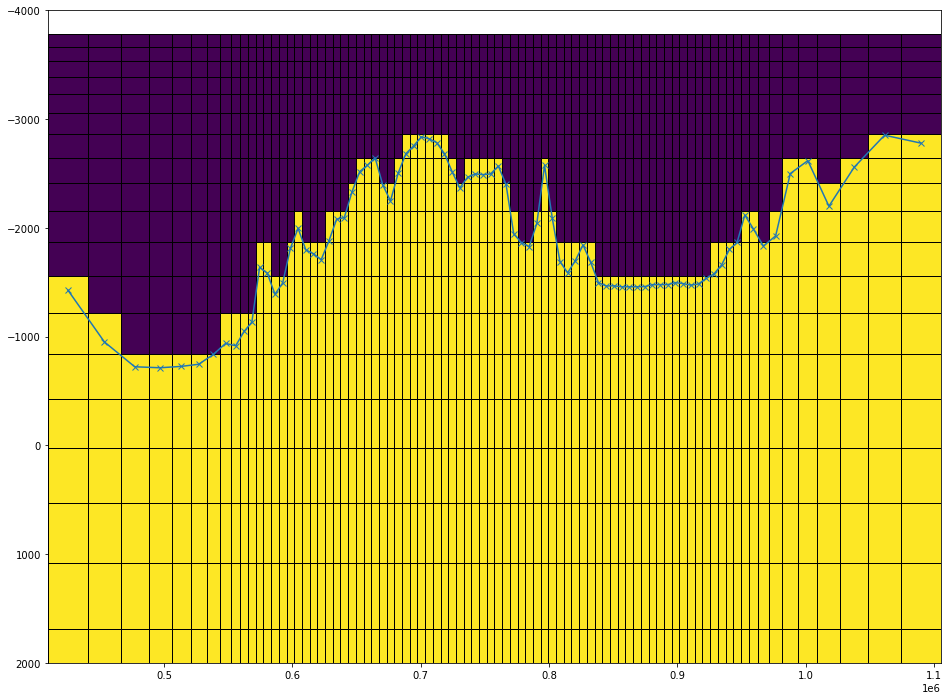

(84,)
(84,)


In [33]:
# set the density values we want to assign to earth and air
earthdens = 1.0
airdens = 0.0
#go through each column of cells and assign air values to all cells above topography and earth values to those below
for i in range(0,Northing.size):
    for j in range(0,Easting.size):
        Density[np.nonzero(Depth < -topointer[i,j]),j,i]  = airdens
        Density[np.nonzero(Depth >= -topointer[i,j]),j,i]  = earthdens
#plot an East-West profile through the resulting model
#also plot the interpolated topography to show how our model and the exact topography values differ
profile = 40
ea, de = np.meshgrid(Ea,De)
plt.figure(figsize=(16,12))
plt.pcolormesh(ea,de,Density[:,:,profile],edgecolors='black')
plt.plot(eastmid,-topointer[profile,:],marker='x')
plt.ylim([2000,-4000])
plt.show()

Now that we have our starting model, we can build the other ingredients for the inversion. For a single method inversion we have to make sure that the values in the Air are not modified and that no regularization is applied across the Air/Earth interface.

We can fix the  values in certain cells of the mesh by supplying the diagonal elements of the prior model covariance matrix $\mathbf{C}_M$. The theory behind the model covariance matrix and what it means in its most general form is described in the book "Inverse Problem Theory" by A. Tarantola, for example. For our purposes three things are important to consider:
- Small diagonal elements of $\mathbf{C}_M$ prevent changes to the corresponding model parameters
- Large diagonal elements of $\mathbf{C}_M$ enhance changes of the corresponding model parameters
- The matrix needs to be inverible, so the diagonal elements cannot be zero.
In general we have fine grained control over how much each cell in the model is allowed to vary. We can use this to allow moderate changes to some cells (e.g. a value of 0.5), "normal" changes to other cells (e.g. a value of 1.0) and strong changes to certain cells (a large value, e.g. 5). In practice, it is very difficult to decide how exactly we want to distribute those values and it will have a strong impact on the inversion results. Therefore, we only use two values for the model covariance: very small (here $10^{-10}) for cells that should not change values and 1 for cells that should be inverted normally. 

In *jif3D* the information about where to apply regularization and where not is called *Tear* and can be specified for all three coordinate direction separately. For each direction we can specify a positive floating point value. Similar to the covariance, a small value (can be 0) corresponds to little regularization, a value of 1 to standard regularization and a large value $\gg 1$ to strong regularization. For each direction the value in a given cell specifies the regularization strength with the next cell in the positive axis direction, i.e. towards the North, East and down directions, respecively.

In [37]:
# Start with values of 1 for the model covariance everywhere
Cov = np.ones(Density.shape)
# set those cells with densities less than Earth density to a small value, 
# needs to be adjusted for more complicated setups with varying values within the Earth
Cov[Density < earthdens] = 1e-10
# Start with the tear information the same as the covariance
TearX = Cov.copy()
TearY = Cov.copy()
# For the z direction we can work with that. In this form there will be no regularization between any cells in the air
# As cells in the air are fixed this does not matter. In cases where you want to create discontinuities within the mdel
#only cells along that discontinuity should be considered
TearZ = Cov.copy()
# We can calculate the tear in x- and y directions by multiplication with a shifted version of the mesh
# in the respective direction. Proof that this works as intended is left as an exercise to the reader :-)
TearX[:,:,:-1] = TearZ[:,:,:-1] * TearZ[:,:,1:]
TearY[:,:-1,:] = TearZ[:,:-1,:] * TearZ[:,1:,:]

To illustrate what the Tear model looks like we plot the tear information in y-direction along the same East-West profile as above. Comparing the two plots we can see that where density values change in the positive y-direction (horizontal direction in the plot), we see small tear values.

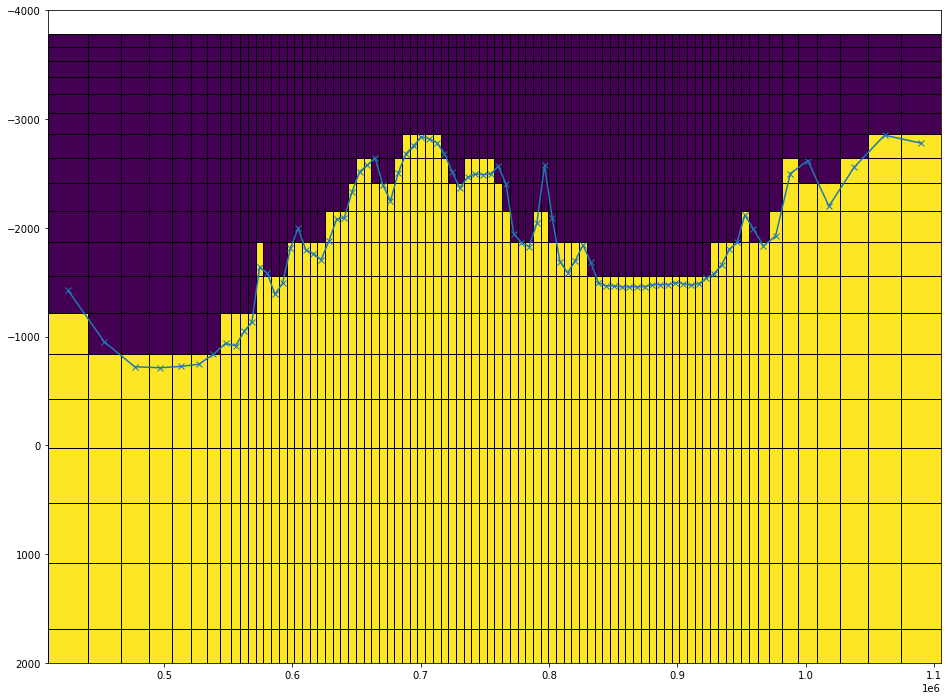

In [39]:
plt.figure(figsize=(16,12))
plt.pcolormesh(ea,de,TearY[:,:,profile],edgecolors='black')
plt.plot(eastmid,-topointer[profile,:],marker='x')
plt.ylim([2000,-4000])
plt.show()

The covariance and tear information is written in the same format as the starting models. For convencience we can use the name of any existing physical property in the joint inversion (Density, Susceptibility, etc.), but we have to make sure the units match the chosen property.

In [18]:
#Define a function to write the various models
def WriteModel(filename, Northing, Easting, Depth, Value, Name, Units):
  model_fh = Dataset(filename, "w")
  Northdim = model_fh.createDimension("Northing", Northing.size)
  Eastdim = model_fh.createDimension("Easting", Easting.size)
  Depthdim = model_fh.createDimension("Depth", Depth.size)
  
         
  vnorth = model_fh.createVariable("Northing","f8",("Northing"))
  vnorth[:] = Northing[:]
  vnorth.units = "m"

  vnorth_orig = model_fh.createVariable("Northing_Origin","f8")
  vnorth_orig[:] = startx
         
  veast = model_fh.createVariable("Easting","f8",("Easting"))
  veast[:] = Easting[:]
  veast.units = "m"
  veast_orig = model_fh.createVariable("Easting_Origin","f8")
  veast_orig[:] = starty
         
  vdepth = model_fh.createVariable("Depth","f8",("Depth"))
  vdepth[:] = Depth[:]
  vdepth.units = "m"
  vdepth_orig = model_fh.createVariable("Depth_Origin","f8")
  vdepth_orig[:] = startz
         
  vdens  = model_fh.createVariable(Name,"f8",("Depth","Easting","Northing"))
  vdens[:,:,:] = Value[:,:,:]
  vdens.units = Units        
  model_fh.close()  
    
# Write the tear and density starting models and the covariance for density
WriteModel("dens_cov.nc",Northing,Easting,Depth,Cov,"Density","kg/m3")
WriteModel("tearx.nc",Northing,Easting,Depth,TearX,"Density","kg/m3")
WriteModel("teary.nc",Northing,Easting,Depth,TearY,"Density","kg/m3")
WriteModel("tearz.nc",Northing,Easting,Depth,TearZ,"Density","kg/m3")
WriteModel("start_grav.nc",Northing,Easting,Depth,Density,"Density","kg/m3")
# Also make a susceptibility starting models with 0 values everywhere and write a model file for that
Susceptibility = np.zeros(Density.shape)    
WriteModel("start_mag.nc",Northing,Easting,Depth,Susceptibility,"Susceptibility"," ")

In order to make this example even more complex and more interesing, we also incorporate Moho depth into the joint inversion. Typcially significant magnetic susceptibility variations are considered to only occur in the crust as the mantle is above the Curie Temperature. If we have good estimates of the Curie Depth (the depth where the temperature within the Earth exceeds the Curie Temperature), we could use that information. For simplicity (and as I could find anything in digital form), we will use the Moho depth estimates of Szwillus et al. (GJI 2019) instead.

Based on the Moho depth we construct a separate covariance for susceptibility where, in addition to the air, also all cells below the Moho are fixed. It is debatable if we should also specify a tear across the Moho. Having a tear at this interface decouples the mantle from the crust which could be considered reasonable. This would have to be the case for all datasets involved in the joint inversion as we can only specify one set of tear models that work equally on all physical properties. For the moment we neglect this possible. With the information provided in the Tutorial it should be easy to modify the Tear files accordingly.

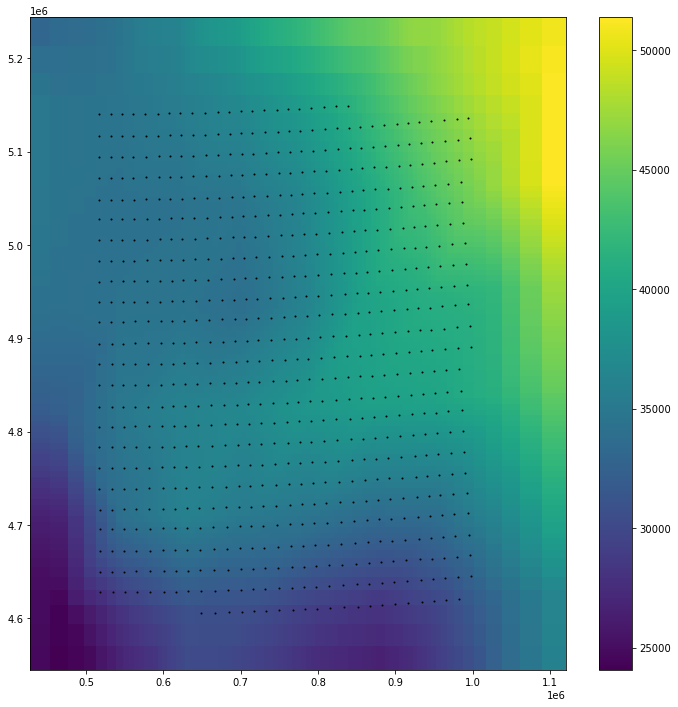

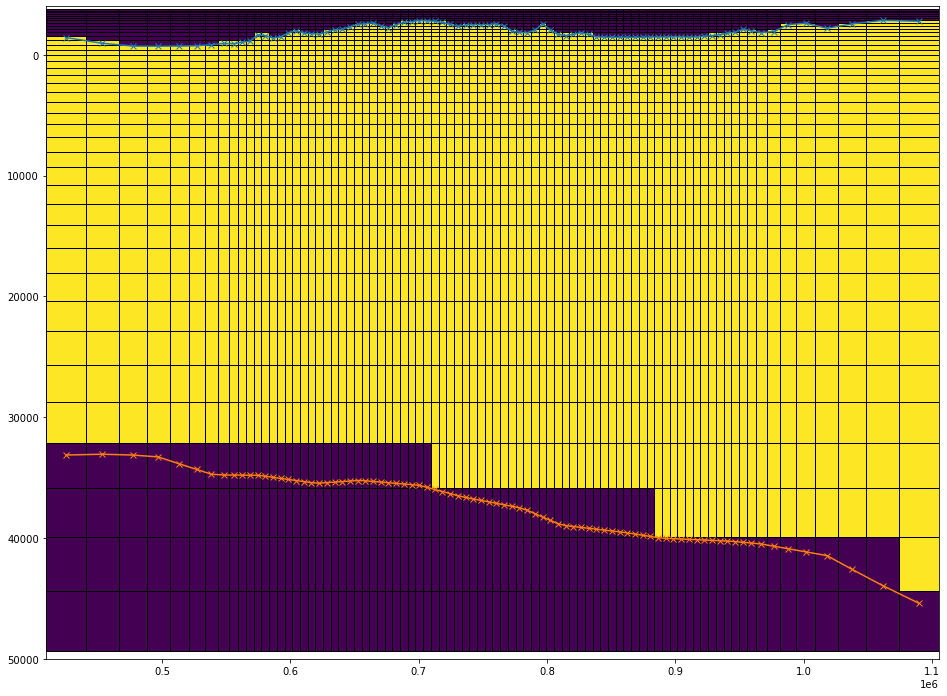

In [46]:
# Read in the Moho information provided by Szwillus et al.
moho =np.genfromtxt('Moho.txt',skip_header=35)
mohoy, mohox = transformer.transform(moho[:,1],moho[:,0])
# convert km to m
mohod = moho[:,2] * 1000.0 

#determine the indices in the moho dataset that fall into the region of interest
ind = (mohox > 4e6) & (mohox < 5.5e6) & (mohoy > 3e5) & (mohoy < 1.3e6)

# interpolate to the mesh in analogy to topography
mohointer = sc.griddata(np.c_[mohoy[ind].flatten(),mohox[ind].flatten()],mohod[ind].flatten(),(grid_x, grid_y), method='linear')

# plot the interpolated Moho
plt.figure(figsize=(12,12))
ea, no = np.meshgrid(Easting,Northing)
plt.pcolormesh(ea,no,mohointer)
plt.colorbar()

plt.scatter(MeasY,MeasX, s=1, c='black')
plt.show()

# set the covariance in all cells below the Moho to a small value
sus_cov = Cov.copy()
mantlecov = 1e-10
for i in range(0,Northing.size):
    for j in range(0,Easting.size):
        sus_cov[np.nonzero(Depth >= mohointer[i,j]),j,i]  = mantlecov
        
# write the covariance information for magnetic susceptibilty        
WriteModel("sus_cov.nc",Northing,Easting,Depth,sus_cov,"Susceptibility"," ")
# plot the covariance along the same profile as above        
profile = 40
ea, de = np.meshgrid(Ea,De)
plt.figure(figsize=(16,12))
plt.pcolormesh(ea,de,sus_cov[:,:,profile],edgecolors='black')
plt.plot(eastmid,-topointer[profile,:],marker='x')
plt.plot(eastmid,mohointer[profile,:],marker='x')
plt.ylim([50000,-4000])
plt.show()

The final ingredient for the joint inversion is the information where we want to apply the coupling. In this case we want to couple the two inversions in the crust and do not consider coupling in the Air (where both are fixed) and in the mantle (where gravity should vary independently). As for the other files, a value of unity means to consider the coupling and a value of less than one no coupling. However, in contrast to the other files this is a simple on/off switch and it is not possible at the moment to have a continuously varying coupling strength with MI coupling. In this example we can simply reuse the Susceptibility covariance file to specify the coupling strength. With all information in place, we can now provide the appropriate options to the joint inversion.

In [54]:
#location of the jif3D executables on your system
execpath = "/home/moorkamp/workspace/jif3D/bin/"
#program we want to run
progname = "jointinv"
#
options = " --dens_covmod dens_cov.nc --tearmodx tearx.nc --tearmody teary.nc --tearmodz tearz.nc --inclination 1.17 --declination 0.22 --fieldstrength 52671 --sus_covmod sus_cov.nc --mutual_information 100 --stochcov 1.0 --coupling_validity sus_cov.nc "
#name of the density starting mesh
gravmesh = "start_grav.nc"
#name of the gravity data file
gravdata = "gravdata.nc"
#weight for standard gravity data, typically 1 in individual inversions
gravweight = 1.0
#weight for the magnetic data, set to zero at the moment as we do not have magnetic data yet
magweight = 1.0
magmesh = "start_mag.nc"
magdata = "magdata.nc"
#The joint inversion can also handle other types of data but we are not interested in those right now
#so we set the corresponding weights to zero to disable them
magvectorweight = 0.0
mtweight = 0.0
dcweight = 0.0
tomographyweight = 0.0
surfacewaveweight = 0.0
#weight for the FTG data, set to zero at the moment as we do not have FTG data 
ftgweight = 0
#weight for the density regularization, higher values = smoother models
gravregularization = 1000.0
magregularization = 1000.0
coupling = 1e6
#maximum number of iterations
iterations = 20
#write all information to file
f = open('run', 'w')
f.write(execpath+progname+options+"<<eof \n")    
f.write(gravmesh+"\n")
f.write(str(gravweight)+"\n")
f.write(str(ftgweight)+"\n")
f.write(gravdata+"\n")
f.write(gravmesh+"\n")
f.write(str(magweight)+"\n")
f.write(str(magdata)+"\n")
f.write(str(magmesh)+"\n")
f.write(str(magvectorweight)+"\n")
f.write(str(mtweight)+"\n")
f.write(str(dcweight)+"\n")
f.write(str(tomographyweight)+"\n")
f.write(str(surfacewaveweight)+"\n")
f.write(str(coupling)+"\n")
f.write(str(gravregularization)+"\n")
f.write(str(magregularization)+"\n")
f.write(str(iterations)+"\n")
f.write("eof\n")
f.close()

Running the joint inversion works as before.

In [55]:
import subprocess
outfile = open("jif3dgravout.out",'w')
subprocess.run(["bash ./run", ""],stdout=outfile,shell=True)
outfile.close()
log = open("jif3dgravout.out",'r')
for line in log:
    print(line)

terminate called after throwing an instance of 'netCDF::exceptions::NcException'
  what():  Permission denied
file: ncFile.cpp  line:94
./run: line 19: 18743 Aborted                 (core dumped) /home/moorkamp/workspace/jif3D/bin/jointinv --dens_covmod dens_cov.nc --tearmodx tearx.nc --tearmody teary.nc --tearmodz tearz.nc --inclination 1.17 --declination 0.22 --fieldstrength 52671 --sus_covmod sus_cov.nc --mutual_information 100 --stochcov 1.0 --coupling_validity sus_cov.nc <<eof
start_grav.nc
1.0
0
gravdata.nc
start_grav.nc
1.0
magdata.nc
start_mag.nc
0.0
0.0
0.0
0.0
0.0
1000000.0
1000.0
1000.0
20
eof



Mesh filename: Scalar Gravimetry Lambda: FTG Lambda: Scalar Gravity Data Filename: Gravity Model Filename:  Setting covariance for density from file. 

Storing sensitivities in memory 

Storing sensitivities on disk 

Scalar gravity will take 1.73645 GB disk space 

Scalar Gravity ndata: 760

Scalar Gravity lambda: 1

Setting global covariance for Density

Total field magnetics Lambda: Total field magnetic Data Filename: Susceptibility Model Filename:  Setting covariance for susceptibility from file: sus_cov.nc

Storing sensitivities in memory 

Storing sensitivities on disk 

Magnetics will take 5.12709 GB disk space 

 Magnetics ndata: 748

 Magnetics lambda: 1

Setting global covariance for Susceptibility

3-component magnetization Lambda: MT Lambda: DCResistivity Lambda: Tomography Lambda: Surface wave tomography Lambda: Working on segment 0

Assigned inversion parameters for Density, startindex: 0

Working on segment 1

Assigned inversion parameters for Susceptibility, startindex:

We read in the inversion results to demonstrate how the inversion has used the covariance and tear information. From the plots below we can also see that density varies in the mantle while susceptibility does not.

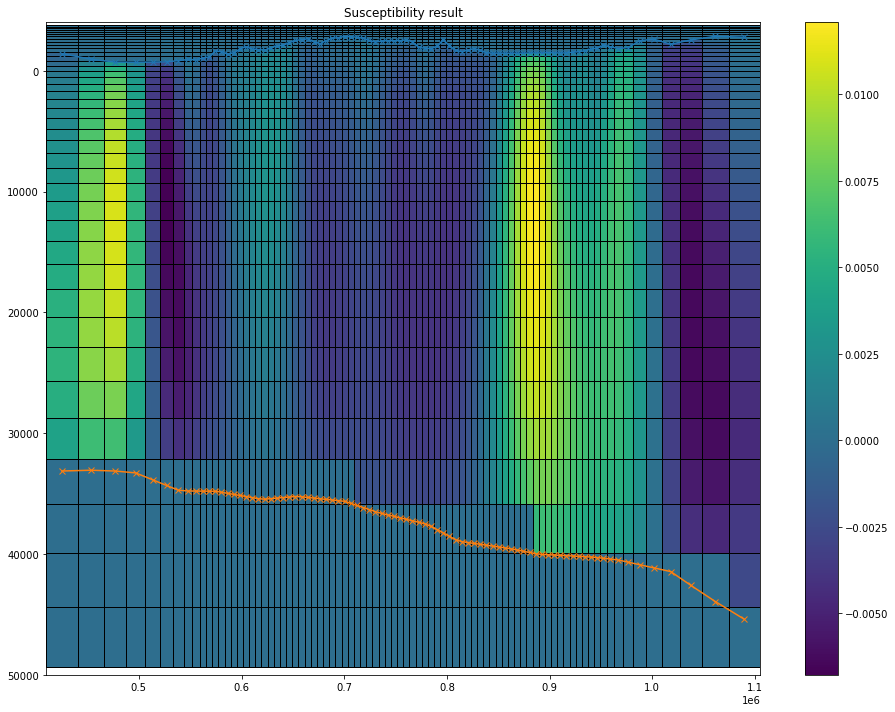

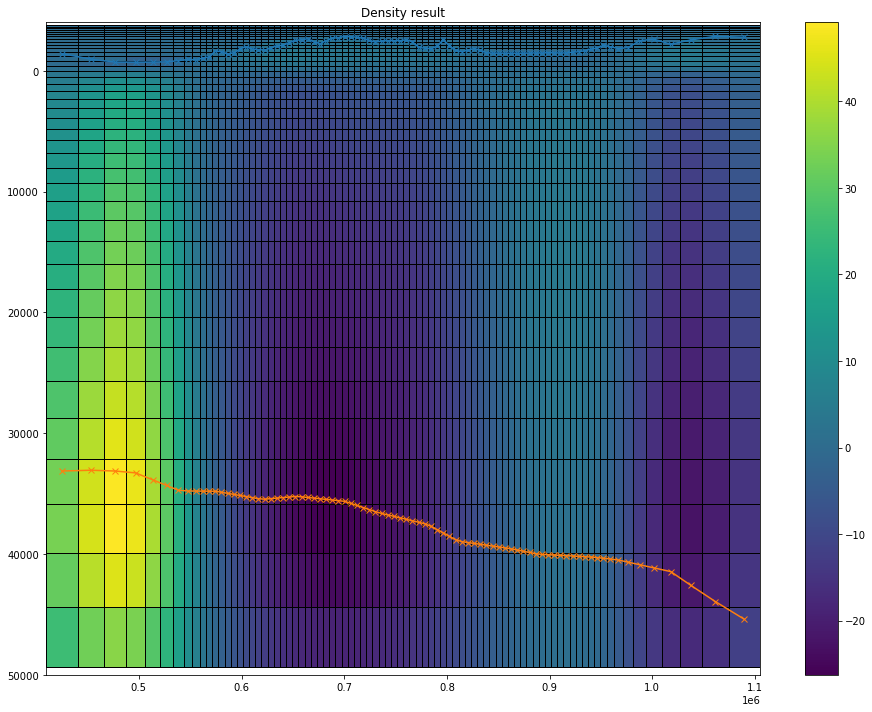

In [59]:
def ReadModel(filename, Name):
  model_fh = Dataset(filename, "r")
  Value = model_fh.variables[Name][:,:,:]    
  model_fh.close() 
  return Value

invdens = ReadModel("result.grav.inv.nc","Density")
invsus = ReadModel("result.mag.inv.nc","Susceptibility")

plt.figure(figsize=(16,12))
plt.pcolormesh(ea,de,invsus[:,:,profile],edgecolors='black')
plt.colorbar()
plt.plot(eastmid,-topointer[profile,:],marker='x')
plt.plot(eastmid,mohointer[profile,:],marker='x')
plt.ylim([50000,-4000])
plt.title("Susceptibility result")
plt.show()

plt.figure(figsize=(16,12))
plt.pcolormesh(ea,de,invdens[:,:,profile],edgecolors='black')
plt.colorbar()
plt.plot(eastmid,-topointer[profile,:],marker='x')
plt.plot(eastmid,mohointer[profile,:],marker='x')
plt.ylim([50000,-4000])
plt.title("Density result")
plt.show()

By extracting the indices where the susceptibility covariance is one (which is identical to the region of coupling), we can plot the parameter relationship only in the region of interest.

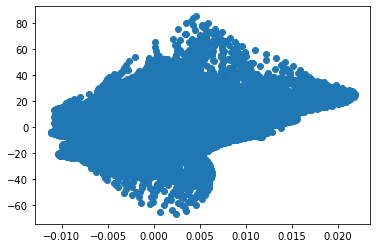

In [58]:
ind = (sus_cov == 1.0)
plt.figure()
plt.scatter(invsus[ind],invdens[ind])
plt.show()